# Common

In [1]:
# print_function for compatibility with Python 3
from __future__ import print_function
print('print function is ready to serve')

# Matplotlib for visualization
from matplotlib import pyplot as plt

# display plots in the notebook
%matplotlib inline

print function is ready to serve


In [2]:
# NumPy for numerical computing
import numpy as np
np.random.seed(123)
import random
random.seed(123)

# Pandas for DataFrames
import pandas as pd
pd.set_option('display.max_column', 100)

from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau

import os
import gc
from skimage import io
from skimage.transform import rescale, resize, downscale_local_mean

Using TensorFlow backend.


In [3]:
import sys
sys.path.append('./utils')

from data import Data
from models import Models

In [4]:
PLANET_KAGGLE_ROOT = '/data/planet-data/'
if not os.path.exists(PLANET_KAGGLE_ROOT):
    PLANET_KAGGLE_ROOT = '/Users/jiayou/Documents/Kaggle Data/Amazon'

N_TAGS = 17
N_TRAIN = 40479
# N_TRAIN = 10
N_TEST_T = 40669
N_TEST_F = 20522
N_TEST = N_TEST_T + N_TEST_F

In [5]:
# img = load_train_image(1)
# plt.imshow(img)
# img.shape

In [6]:
train_labels = pd.read_csv(os.path.join(PLANET_KAGGLE_ROOT, 'train_v2.csv'))
train_labels.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


# Training

In [7]:
def train(toy=None):
    d = Data(tif=False, toy=toy)

    m = Models.new_resnet50(input_shape=(256,256,3))

    if toy is None:
        h = m.fit_generator(
            d.gen_train(32), steps_per_epoch=1000,
            epochs=40, initial_epoch=0,
            validation_data=d.gen_val(100), validation_steps=80,
            callbacks=[
                ModelCheckpoint('weights-v9.hdf5', save_best_only=True, verbose=1),
                ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=0, verbose=1)],
            max_q_size=10)
    else:
        h = m.fit_generator(
            d.gen_train(1), steps_per_epoch=8,
            epochs=40, initial_epoch=0,
            validation_data=d.gen_val(2), validation_steps=1,
            callbacks=[
                ModelCheckpoint('weights-v9.hdf5', save_best_only=True, verbose=1),
                ReduceLROnPlateau(monitor='loss', factor=0.2, patience=1, min_lr=0, verbose=1)],
            max_q_size=10)
        
    return (m, h)

In [8]:
m, h = train(10)

Loading data...
Getting 2 training images...
Got 1 images
Done
Loaded fold 0.
Getting 2 training images...
Got 1 images
Done
Loaded fold 1.
Getting 2 training images...
Got 1 images
Done
Loaded fold 2.
Getting 2 training images...
Got 1 images
Done
Loaded fold 3.
Getting 2 training images...
Got 1 images
Done
Loaded fold 4.
Epoch 1/40
8/8 [==============================] - 46s - loss: 0.7543 - amazon_score: 0.5202 - acc: 0.7574 - val_loss: 0.5708 - val_amazon_score: 0.4000 - val_acc: 0.7647
Epoch 2/40
8/8 [==============================] - 20s - loss: 0.4277 - amazon_score: 0.6844 - acc: 0.8750 - val_loss: 0.4590 - val_amazon_score: 0.4630 - val_acc: 0.7941
Epoch 3/40
8/8 [==============================] - 20s - loss: 0.3359 - amazon_score: 0.7122 - acc: 0.8676 - val_loss: 0.3800 - val_amazon_score: 0.7143 - val_acc: 0.8824
Epoch 4/40
8/8 [==============================] - 20s - loss: 0.2656 - amazon_score: 0.7365 - acc: 0.8750 - val_loss: 0.2899 - val_amazon_score: 0.6944 - val_acc: 0

# Prediction

In [220]:
im = io.imread(os.path.join(PLANET_KAGGLE_ROOT, 'train-tif-v2', 'train_{}.tif'.format(5)))
im = calib_image(im)
im = im[:3,:3,:]
im_rot = np.rot90(im, 1, (0, 1))
im_mir = np.flip(im_rot, 1)
im_mir
# plt.imshow((im[:,:,3] + 3) / 6)
# plt.hist(np.reshape(im[:,:,0:3], (256*256*3, 1)))

array([[[ 1.4523412 ,  1.82022905,  1.88019753,  0.34845296],
        [ 1.50437021,  1.8614527 ,  1.90796089,  0.40385464],
        [ 1.55957162,  1.90791118,  1.93158937,  0.40884078]],

       [[ 1.48152816,  1.81041384,  1.89614677,  0.30745572],
        [ 1.49294913,  1.84902012,  1.90441668,  0.38834217],
        [ 1.50246668,  1.89286125,  1.89850962,  0.41161087]],

       [[ 1.45424473,  1.80256164,  1.86483908,  0.4121649 ],
        [ 1.51769459,  1.86603308,  1.91032374,  0.44152778],
        [ 1.45424473,  1.86537874,  1.88196969,  0.43875769]]], dtype=float32)

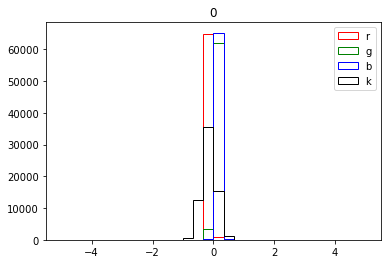

In [167]:
for n in range(1):
    im = io.imread(os.path.join(PLANET_KAGGLE_ROOT, 'train-tif-v2', 'train_{}.tif'.format(n)))
    im = calib_image(im)
    plt.figure()
    plt.title(n)
    for i, color in enumerate(['r','g','b','k']):
        plt.hist(np.reshape(im[:,:,i], (256*256)), bins=30, label=color, color=color, histtype='step', range=[-5, 5])
    plt.legend()

In [70]:
im = io.imread(os.path.join(PLANET_KAGGLE_ROOT, 'train-tif-v2', 'train_{}.tif'.format(0)))
im = im.astype('float32')
im = im / 10000 - 0.5
np.save(os.path.join(PLANET_KAGGLE_ROOT, 'train_0.tif.npy'), im)

In [127]:
a = np.zeros((4,2,2,2))
b = a[[1,2],:,:,:]
b[0,0,:,:] = np.array([1,2,3,4]).reshape((2,2))
b

array([[[[ 1.,  2.],
         [ 3.,  4.]],

        [[ 0.,  0.],
         [ 0.,  0.]]],


       [[[ 0.,  0.],
         [ 0.,  0.]],

        [[ 0.,  0.],
         [ 0.,  0.]]]])

In [339]:
d = Data()
g = d.gen_train(3)
x, y = next(g)

Loading data...
Loaded fold 0.
Loaded fold 1.
Loaded fold 2.
Loaded fold 3.
Loaded fold 4.


'primary agriculture clear water'

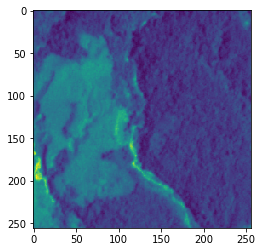

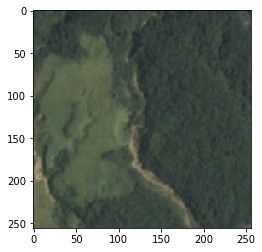

In [335]:
f = 1
k = 0
im = d.X[f][k,:,:,::-1].reshape((256,256,4)).astype('float64')
plt.imshow((im[:,:,2] + np.min(im[:,:,2])) / (np.max(im[:,:,2]) - np.min(im[:,:,2])))
jpg = load_train_image(5*k+f)
plt.figure()
plt.imshow(jpg)
pred_to_tags(d.y[f][k,:].reshape((17)))

'primary agriculture clear water cultivation'

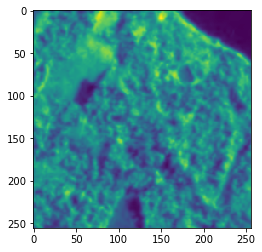

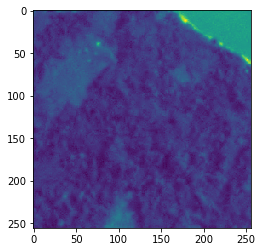

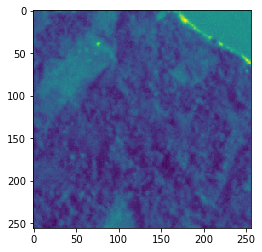

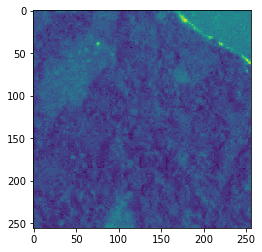

In [347]:
x, y = next(g)
im = x[0,:,:,::-1].reshape((256,256,4)).astype('float64')
for c in range(4):
    plt.figure()
    plt.imshow((im[:,:,c] + np.min(im[:,:,c])) / (np.max(im[:,:,c]) - np.min(im[:,:,c]))) 
    im[:,:,c] = (im[:,:,c] + np.min(im[:,:,c])) / (np.max(im[:,:,c]) - np.min(im[:,:,c]))
pred_to_tags(y[0,:].reshape((17)))

In [ ]:
{0: 'haze',
 1: 'primary',
 2: 'agriculture',
 3: 'clear',
 4: 'water',
 5: 'habitation',
 6: 'road',
 7: 'cultivation',
 8: 'slash_burn',
 9: 'cloudy',
 10: 'partly_cloudy',
 11: 'conventional_mine',
 12: 'bare_ground',
 13: 'artisinal_mine',
 14: 'blooming',
 15: 'selective_logging',
 16: 'blow_down'}